In [1]:
###############################################################################
# 
# author: Jonathan Fisher
#         j.fisher@fz-juelich.de
#         jonathan.m.fisher@gmail.com
#
# description:
#     generates (obviously fake) simulated biodiff data,
#  with and without slowly varying background. This is used
#  in functional tests of nsxlib.
#
###############################################################################

import numpy as np
import math
import pynsx as nsx
import h5py

pi2 = np.pi / 2.0
wavelength = 2.67
dmin = 1.5
dmax = 50.0
infile = "/home/jonathan/git/nsxtool/tests/data/blank.hdf"
outfile = "/home/jonathan/git/nsxtool/tests/data/simulated.hdf"

group_name = "P 21 21 21"
group = nsx.SpaceGroup(group_name)

from matplotlib import pyplot as plt

def correct_image(image):
    baseline = 227.0
    gain = 8.0
    return gain*(image+baseline)

def poisson_noise(image):
    return np.sqrt(image)*np.random.normal(0, 1, image.shape)

exp = nsx.Experiment("Simulated", "BioDiff2500")
diff = exp.getDiffractometer()
reader = nsx.HDF5DataReader(infile, diff)
data = nsx.DataSet(reader, diff)
exp.addData(data)

U = np.random.rand(3,3)
U = np.identity(3) + U.dot(U.transpose())
eig, U = np.linalg.eig(U)

uc = nsx.UnitCell(45.0, 55.0, 65.0, pi2, pi2, pi2)
new_basis = U.dot(uc.basis()).dot(U.transpose())
uc.setBasis(new_basis)

uc.setSpaceGroup(group_name)

det_shape = nsx.Ellipsoid(np.array([800.0, 450.0, 10.0]), 5.0)
peak = nsx.Peak3D(data, det_shape)
peak.setSelected(True)

hkls = uc.generateReflectionsInShell(dmin, dmax, wavelength)
len(hkls)

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


199588

In [2]:
print(data.nFrames())

166


In [13]:
qs = nsx.ReciprocalVectorList()
B = uc.reciprocalBasis()

for hkl in hkls:
    q = hkl.rowVector().dot(B)
    qs.push_back(nsx.ReciprocalVector(q))

In [14]:
events = data.getEvents(qs)
len(events)

32195

In [27]:
sigmaD = 0.3
sigmaM = 0.2

peaks = []

for event in events:
    center = np.array([event._px, event._py, event._frame])
    peak = nsx.Peak3D(data, nsx.Ellipsoid(center, 5.0))
    coords = nsx.PeakCoordinateSystem(peak)
    shape = coords.detectorShape(sigmaD, sigmaM)
    peak.setShape(shape)
    peaks.append(peak)

In [33]:
A = np.random.rand(3,3)
A /= np.linalg.norm(A)
A = 0.5*np.identity(3) + A.dot(A.transpose())
A /= np.linalg.norm(A)
A *= 50


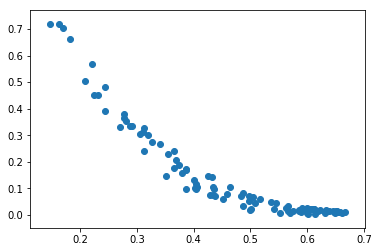

In [34]:
import random
from matplotlib import pyplot as plt

qs = []
Is = []

for i in range(100):
    peak = random.sample(peaks, 1)[0]
    q = peak.q().rowVector()
    qs.append(np.linalg.norm(q))
    
    new_I = 0
    
    elements = group.groupElements()
    for el in elements:
        g = el.getRotationPart()
        gq = q.dot(g)
        new_I += np.exp(-gq.dot(A).dot(gq.transpose()).trace() / 2.0)
        
    I = new_I / len(elements)    
    Is.append(I)
    #print(I)
       
        
plt.scatter(qs, Is)
plt.show()

In [35]:
np.linalg.eig(A)

(array([43.46985015, 16.19061403, 18.66108638]),
 array([[ 0.76209309,  0.62929785, -0.15230999],
        [ 0.33440359, -0.58399537, -0.73967807],
        [ 0.55442615, -0.51277054,  0.65549829]]))

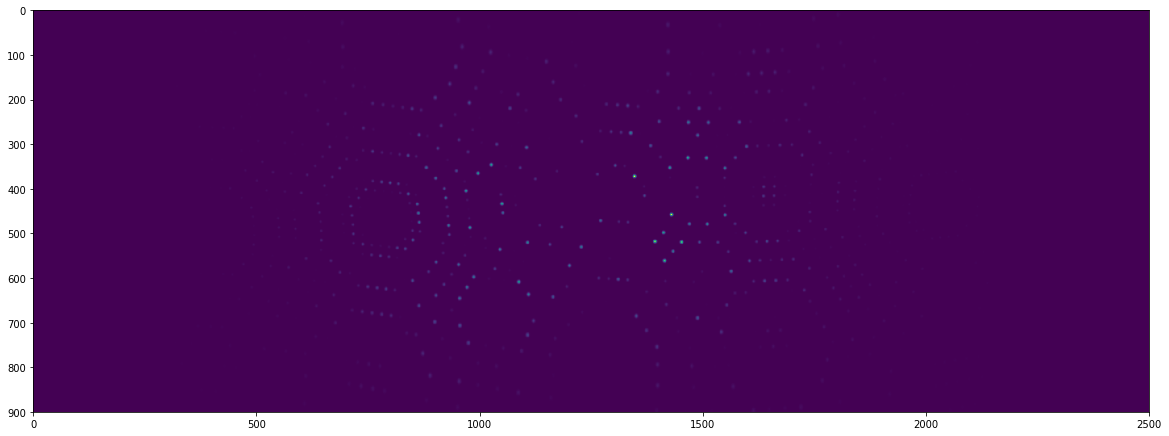

In [43]:
def frame_peaks(idx, peaks, nsigma):
    in_frame = []
    
    for peak in peaks:
        center = peak.getShape().center()
        extents = peak.getShape().aabb().extents()
        
        df = extents[2] / 2.0
        
        if abs(center[2]-idx) > nsigma*df:
            continue
            
        in_frame.append(peak)
        
    return in_frame


def generate_frame(idx, peaks):
    Imax = 200**2
    nsigma = 4
    image = np.array(data.frame(idx), dtype=np.float)
    rows, cols = image.shape
       
    in_frame = frame_peaks(idx, peaks, nsigma)
    #print(len(in_frame))
    elements = group.groupElements()
    gs = [ el.getRotationPart() for el in elements ]
    
    for peak in in_frame:
        aabb = peak.getShape().aabb()
        shape = peak.getShape()
        center = shape.center()
        inv_cov = shape.metric()
        extents = aabb.extents()
        
        I = 0        
        q = peak.q().rowVector().transpose()        
        
        for g in gs:
            gq = g.dot(q)
            I += Imax * np.exp(-0.5*gq.transpose().dot(A).dot(gq).trace())
            
        I /= len(gs)
        #print("intensity", I)
        
        xmin = int(center[0,0] - nsigma*extents[0,0]/2)
        xmax = int(center[0,0] + nsigma*extents[0,0]/2)
        
        ymin = int(center[1,0] - nsigma*extents[1,0]/2)
        ymax = int(center[1,0] + nsigma*extents[1,0]/2)
        
        zmin = int(center[2,0] - nsigma*extents[2,0]/2)
        zmax = int(center[2,0] + nsigma*extents[2,0]/2)
        
        xmin = max(0, xmin)
        xmax = min(data.nCols(), xmax)
        
        ymin = max(0, ymin)
        ymax = min(data.nRows(), ymax)
        
        zmin = max(0, zmin)
        zmax = min(data.nFrames(), zmax)
        
        x = range(xmin, xmax)
        y = range(ymin, ymax)
        #z = range(zmin, zmax)
        z = idx
        
        #print("x:", x)
        #print("y:", y)
        
        #print("dx:", np.array(x)-center[0,0])
        #print("dy:", np.array(y)-center[1,0])
        
        x, y = np.meshgrid(x, y)
        
        
        
        dx = x-center[0,0]
        dy = y-center[1,0]
        dz = z-center[2,0]
        
        
        #print("dx", dx.transpose())
        
        M = shape.metric()
        #print(M.shape)
        #print(dx.shape)
        #print(x.shape)
        arg = dx**2 * M[0,0] + dy**2 * M[1,1] + dz**2 * M[2,2]
        arg += 2*dx*dy*M[0,1] + 2*dx*dz*M[0,2] + 2*dy*dz*M[1,2]
        
        #print("arg:", arg)
        
        
        coef = np.sqrt(np.linalg.det(M/2/np.pi))
        #print("coef:", coef)
        
        inten = coef*I * np.exp(-0.5*arg)
        #print("integrated intensity", inten.sum())
        image[ymin:ymax, xmin:xmax] += inten   
        
        #break
    
    return image

im = generate_frame(50, peaks)
plt.figure(figsize=(20,10))
plt.imshow(im)
plt.show()

In [44]:
s = data.interpolatedState(50.0)
s.sampleOrientationMatrix()

array([[ 0.96592583,  0.25881905,  0.        ],
       [-0.25881905,  0.96592583, -0.        ],
       [-0.        ,  0.        ,  1.        ]])

In [45]:
im.mean()

0.4364963069579826

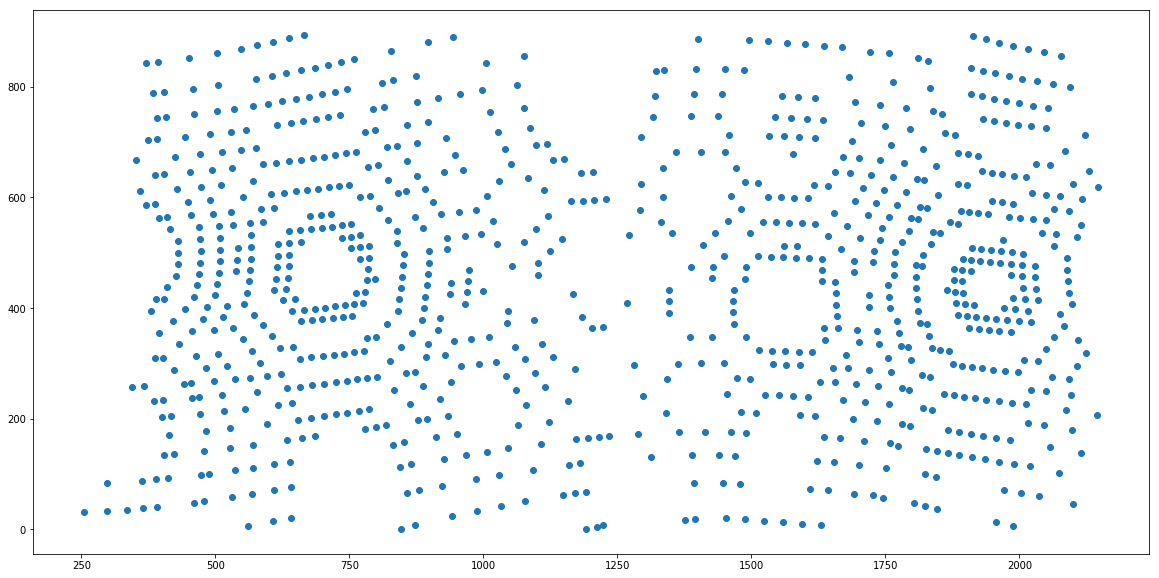

In [46]:
in_frame = frame_peaks(10, peaks, 3)

xs = []
ys = []

for peak in in_frame:
    c = peak.getShape().center()
    xs.append(c[0,0])
    ys.append(c[1,0])

plt.figure(figsize=(20,10))
plt.scatter(xs, ys)
plt.show()

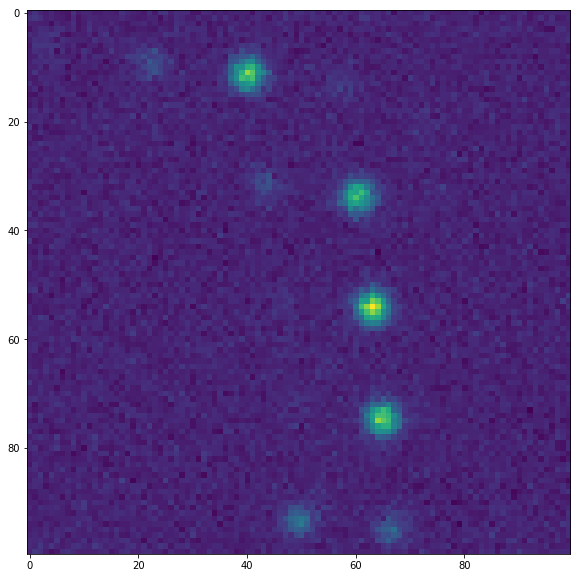

In [48]:
bkg = 40
noise = poisson_noise(bkg+im)
plt.figure(figsize=(20,10))
plt.imshow((bkg+im+noise)[400:500, 800:900])
plt.show()

In [14]:
noise.std()

7.260018566789065

In [15]:
im.mean()

12.659280884605693

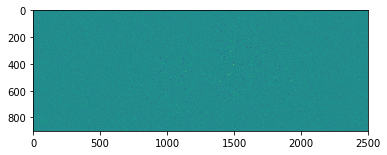

In [16]:
plt.imshow(noise)
plt.show()

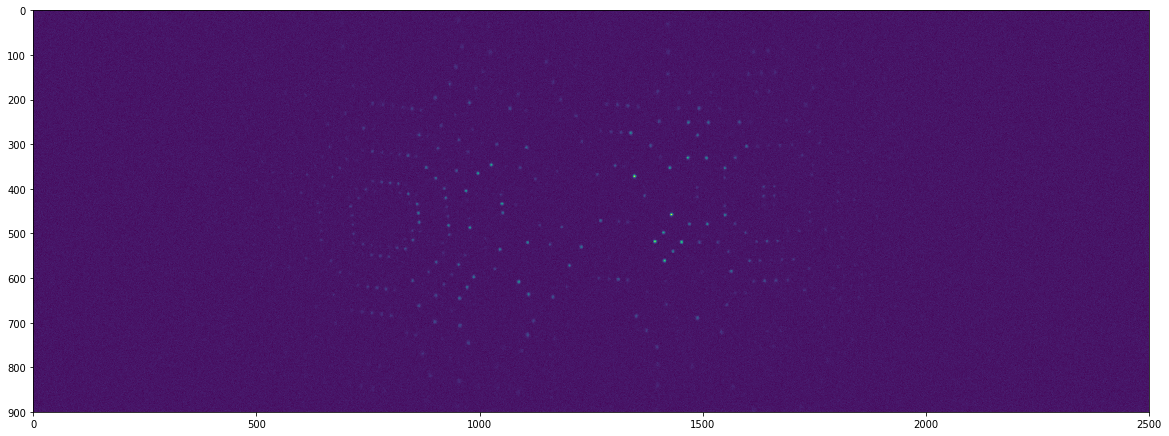

In [49]:
simulated = correct_image(bkg + noise + im)
plt.figure(figsize=(20,10))
plt.imshow(simulated)
plt.show()

In [50]:
def background():
    return 40.0

In [51]:
N = data.nFrames()
delta = 0.3 # hard coded!!

with h5py.File(outfile, "w") as f:
    data_grp = f.create_group("Data")
    scan = f.create_group("Data/Scan")
    expr = f.create_group("Experiment")
    info = f.create_group("Info")
    
    images = data_grp.create_dataset("Counts", (N, 900, 2500,), dtype='i4', compression="gzip", compression_opts=9)
    
    scan.create_dataset("Sample/chi", (N,), dtype="f8")
    omega = scan.create_dataset("Sample/omega", (N,), dtype="f8")
    scan.create_dataset("Sample/phi", (N,), dtype="f8")
    
    scan.create_dataset("Source/chi-mono", (N,), dtype="f8")
    scan.create_dataset("Source/om-mono", (N,), dtype="f8")
    scan.create_dataset("Source/phi-mono", (N,), dtype="f8")
    scan.create_dataset("Source/x-mono", (N,), dtype="f8")
    scan.create_dataset("Source/y-mono", (N,), dtype="f8")
    
    scan.create_dataset("Detector/2theta(gamma)", (N,), dtype="f8")
    
    expr.attrs.create("npdone", N, dtype="i4")
    expr.attrs.create("monitor", 0.0)
    expr.attrs.create("wavelength", 2.67)
    expr.attrs.create("Numor", 0, dtype="i4")
  
    info.attrs.create("Instrument", b"BioDiff2500")
    
       
    bkg = background()
        
    #for i in range(N):        
    for i in range(10):        
        simulated = generate_frame(i, peaks) + bkg
        noise = poisson_noise(simulated)        
        simulated += noise
        simulated = correct_image(simulated)
        images[i] = simulated
        omega[i] = i*delta
        
        print(i, images[i].mean())
        
        
    f.flush()
    f.close()
    
print("Done simulating data.")

0 2137.3755742222224
1 2138.8269897777777
2 2139.13226
3 2139.6294382222222
4 2139.8259853333334
5 2139.830270222222
6 2139.737356
7 2139.4396986666666
8 2139.1879115555557
9 2138.9059177777776
Done simulating data.


In [22]:
print(42)

42


In [ ]:
help(h5py.File)